In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

In [2]:
def get_ensemble(name,data_vars,htape,keys,paramkey,p=True):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=p,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0' or htape=='h1':
        ds['time'] = xr.cftime_range(str(2005),periods=len(ds.time),freq='MS') #fix time bug

    #specify extra variables    
    if htape=='h0':
        extras     = ['grid1d_lat','grid1d_lon']
    elif htape=='h1':
        extras     = ['pfts1d_lat','pfts1d_lon','pfts1d_wtgcell','pfts1d_itype_veg']
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax/biome
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    whit         = xr.open_dataset('./whit/whitkey2.nc')
    ds['biome']      = whit['biome']
    ds['biome_name'] = whit['biome_name']
    
    return ds


In [3]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [4]:
def get_cfs():
    df = pd.read_csv('agg_units.csv')
    cfs   = dict()
    units = dict()
    for i,row in df.iterrows():
        f = row['field']
        u = row['unit']
        c = row['cf']

        cfs[f]   = c
        units[f] = u
    return cfs,units

In [95]:
def find_pair(da,params,minmax,p):
    '''
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])
    
def top_n(da,nx,params,minmax,uniques):
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

def plot20(da,nx,tstr,ll=True,xstr=''):
    
    uniques = list(np.unique(ds.param))
    uniques.remove('default')
    
    xmins,xmaxs,pvals = top_n(da,nx,params,minmax,uniques)
    xdef = da.isel(ens=0)
    unit = da.attrs['units']
    

    
    if len(xstr)==0:
        xstr=tstr
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    if ll:
        plt.legend(loc=3)
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(tstr)
    plt.xlabel(xstr+' ('+unit+')');

In [5]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [6]:
# Setup your PBSCluster
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45049 instead
  f"Port {expected} is already in use.\n"


In [7]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.57:36591,Workers: 0
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Total threads: 0
Started: Just now,Total memory: 0 B


## START HERE

### load ensemble

In [15]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/surv.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#fetch unit/cf dicts
cfs,units = get_cfs()

In [80]:
env = 'CTL2010'
keys = paramkey.key
data_vars = ['GPP','NPP','NBP','TWS','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TOTVEGC','TOTSOMC_1m','FCEV','FGEV','COL_FIRE_CLOSS','QHR','ALTMAX',
             'QOVER','QDRAI','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']
ds = get_ensemble(env,data_vars,'h0',keys,paramkey)
params = ds.param
minmax = ds.minmax

### global annual avg / iav

In [84]:
def calc_mean(ds,datavar,la,dim='gridcell'):
    preload = './data/'+env+'_'+datavar+'_glob.nc'
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        x  = ds[datavar]

        #calc annual mean or sum (determined by cf)
        if datavar=='ALTMAX':
            ## unique logic for ALTMAX
            ix   = ds.ALTMAX.isel(ens=0).mean(dim='time')<10
            xann = cf*(la*ds.ALTMAX.where(ix).groupby('time.year').max()).sum(dim=dim).compute()
        else:
            xann = cf*(month_wts(10)*(la*x).sum(dim=dim)).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')
        
        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = ds.param
        out['minmax'] = ds.minmax
        out.load().to_netcdf(preload)
    

    #load from file if available
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav

### GPP

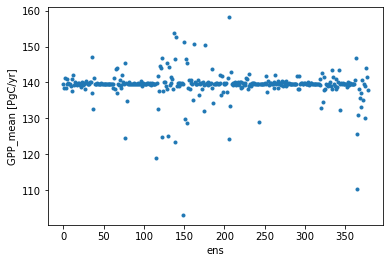

In [85]:
datavar = 'GPP'
gpp,iav = calc_mean(ds,datavar,la,dim='gridcell')
gpp.plot.line('.');

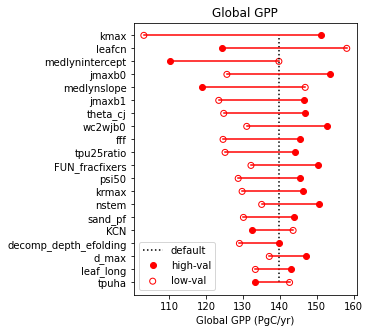

In [96]:
plt.figure(figsize=[4,5])
plot20(gpp,20,'Global GPP')

### SNOWDP

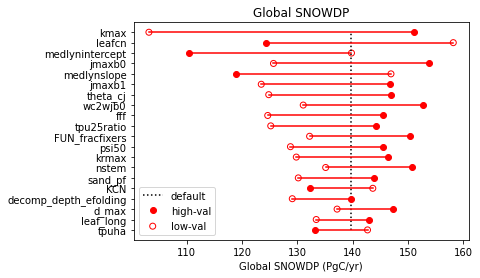

In [101]:
datavar = 'SNOWDP'
da,iav = calc_mean(ds,datavar,la,dim='gridcell')
plot20(gpp,20,'Global '+datavar)